<a href="https://colab.research.google.com/github/JaxDoge/CS6410/blob/main/Group5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade datasets
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 28.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.1 MB/s eta 0:00:00


Import all necessary libraries

# Loading Data

In [3]:
from datasets import load_dataset

import pyarrow as pa
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from joblib import Memory
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tempfile import mkdtemp

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, label_binarize
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import torch

Import Dataset

In [4]:
dataset = load_dataset("mstz/covertype", "covertype")["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/581012 [00:00<?, ? examples/s]

In [5]:
seed = 123
cv_fold = 3

df_new = dataset.to_pandas()


# Drop rows if responsor is missing
df_new = df_new.dropna(subset=['cover_type'])
df_new.shape

(581012, 55)

# Data Analysis

(2905, 55)


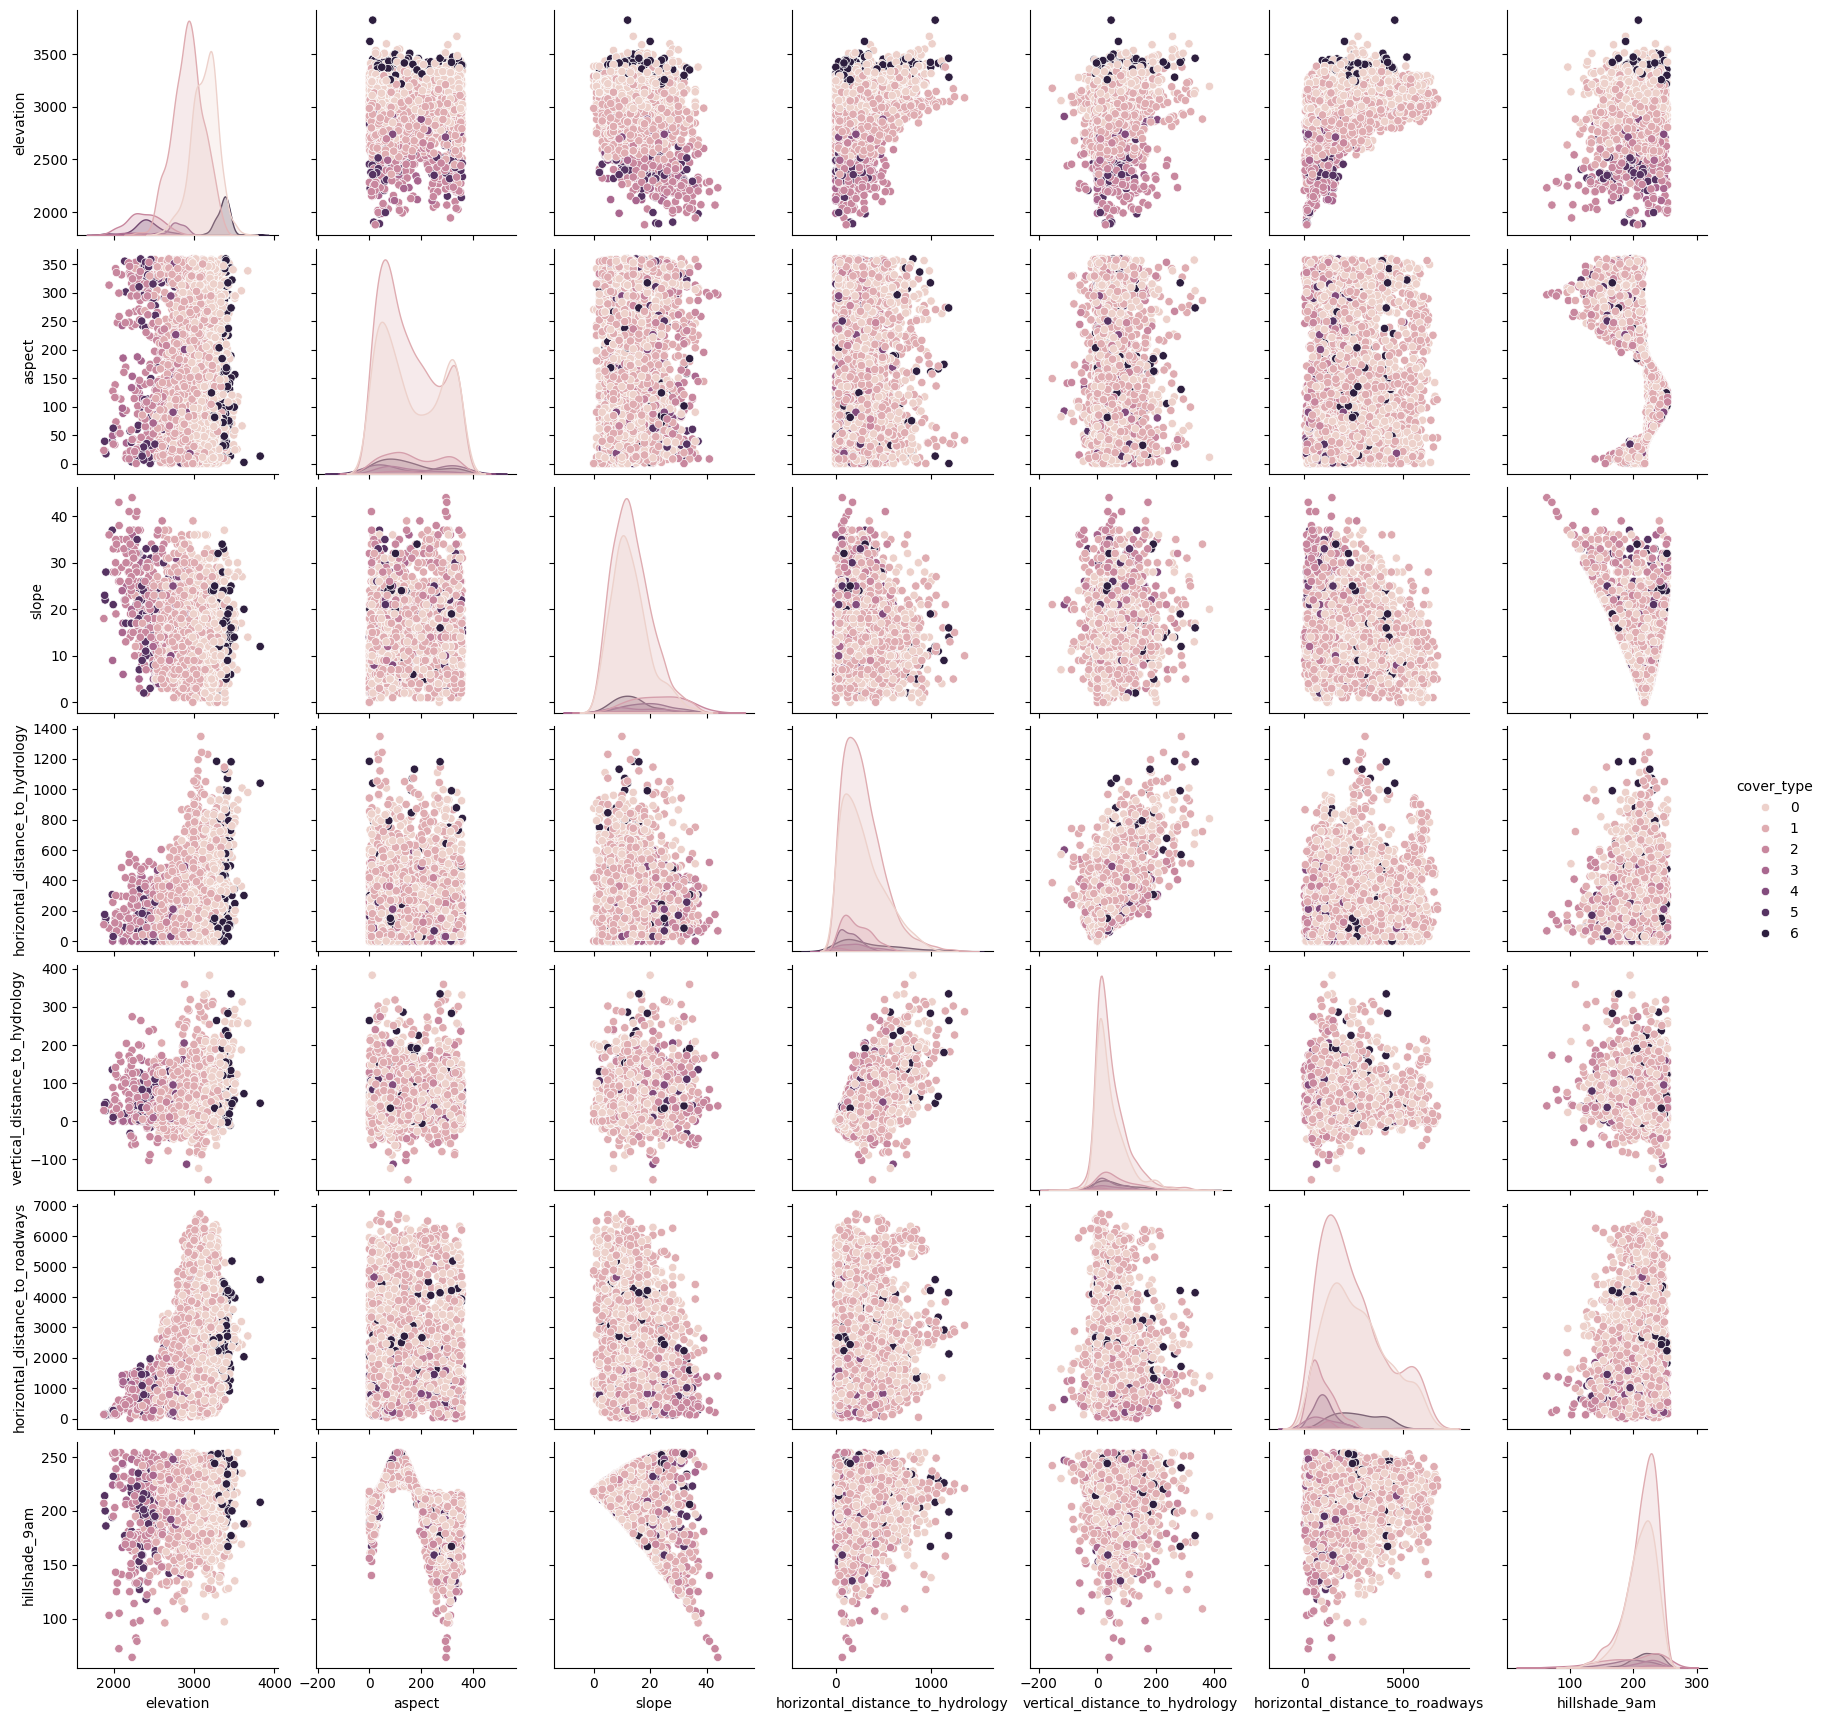

In [6]:
# prompt: Plotting attributes variables relation to  covertype
# Plot the attributes variables relation to covertype
plot_df_new = df_new.sample(frac = 0.005)
print(plot_df_new.shape)
sns.pairplot(plot_df_new.iloc[:, [0,1,2,3,4,5,6,54]], hue="cover_type")
plt.show()


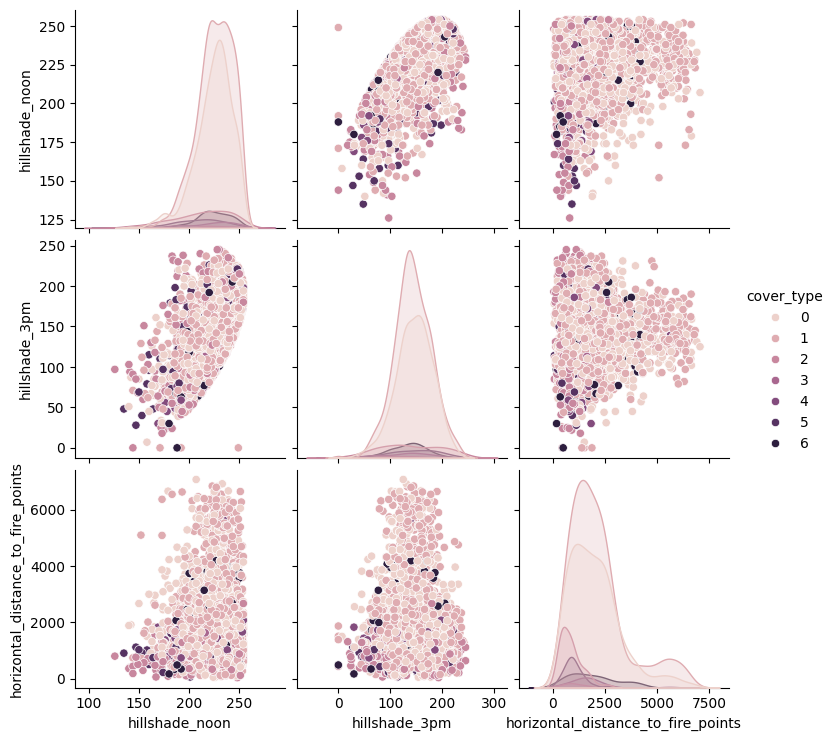

In [7]:
sns.pairplot(plot_df_new.iloc[:, [7,8,9,54]], hue="cover_type")
plt.show()

In [8]:
# Statistical Analysis
# Calculating correlation matrix
correlation_matrix = plot_df_new.iloc[:, [0,1, 2, 3, 4,5,6,7,8,9,54]].corr()
print(correlation_matrix)


                                    elevation    aspect     slope  \
elevation                            1.000000  0.017023 -0.289597   
aspect                               0.017023  1.000000  0.055494   
slope                               -0.289597  0.055494  1.000000   
horizontal_distance_to_hydrology     0.311009 -0.021598 -0.042498   
vertical_distance_to_hydrology       0.118444  0.039368  0.225714   
horizontal_distance_to_roadways      0.372011  0.041373 -0.242363   
hillshade_9am                        0.135756 -0.566434 -0.349894   
hillshade_noon                       0.235842  0.358648 -0.525045   
hillshade_3pm                        0.063418  0.654212 -0.157390   
horizontal_distance_to_fire_points   0.139708 -0.120312 -0.196639   
cover_type                          -0.256891 -0.023346  0.151290   

                                    horizontal_distance_to_hydrology  \
elevation                                                   0.311009   
aspect                     

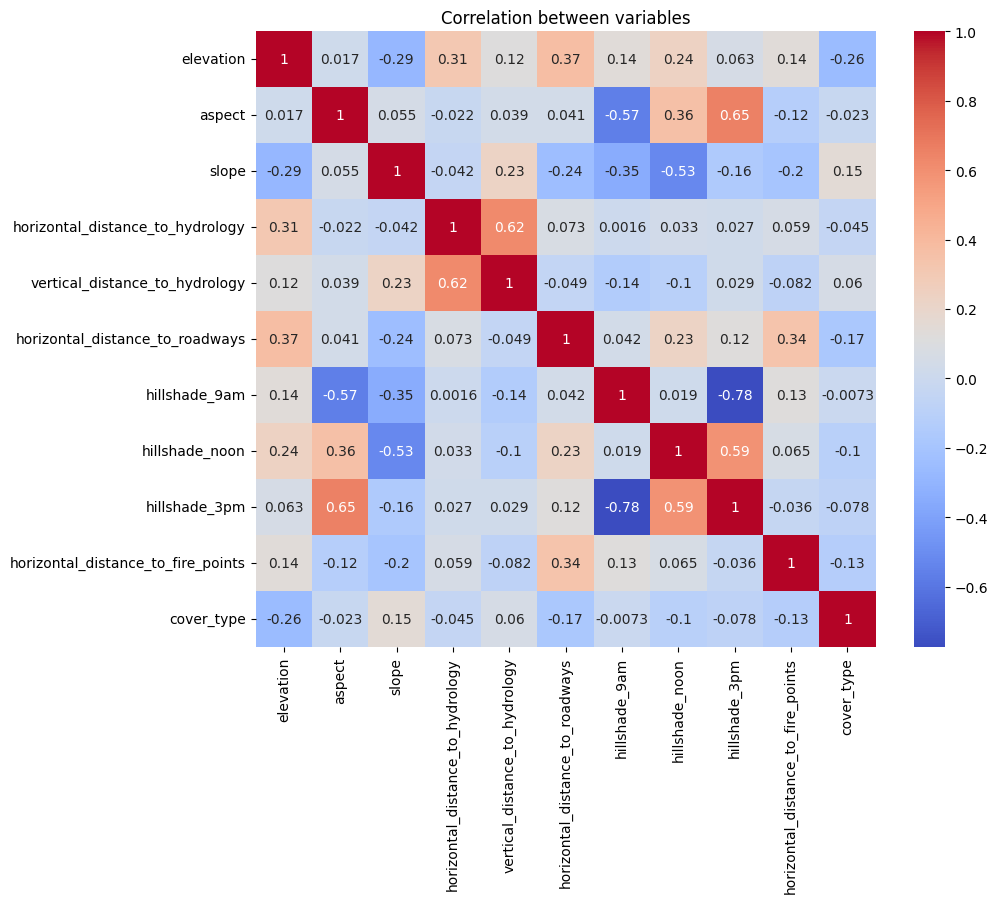

In [9]:
#  Advanced Visualization - Heatmap of the Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between variables')
plt.show()

Data Pre-Processing

In [10]:
X = df_new.drop('cover_type', axis = 1)
y = df_new['cover_type']

In [11]:
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
bool_features = X.select_dtypes(include=['bool']).columns.tolist()

In [12]:
# Manually apply transformation to each boolean feature
for column in bool_features:
    X[column] = X[column].astype(int)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

In [14]:
# Check outliers
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(X_train.loc[:, numerical_features])
df_scaled = pd.DataFrame(scaled_data, columns=numerical_features)

# Identifying rows where any numerical feature has a Z-score greater than 3 or less than -3 considered outlier
outliers = (np.abs(df_scaled) > 3).any(axis=1)

print("Detected Outliers:")
print(sum(outliers))

Detected Outliers:
33514


In [15]:
outliers.index = X_train.index
X_train_filtered = X_train[~outliers]
y_train_filtered = y_train[~outliers]

In [16]:
# Function to convert booleans to integers
def bool_to_int(x):
    return x.astype(int)

In [17]:
# Define scorers with multi-class handling
def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    y_true = label_binarize(y_true, classes=np.unique(y_true))

    return roc_auc_score(y_true, y_pred, average=average, multi_class="ovr")

In [18]:
# For numerical values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# For Bool value
bool_transformer = Pipeline(steps=[
    ('bool_to_int', FunctionTransformer(bool_to_int))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('bool', 'passthrough', bool_features)
    ])

In [19]:
# Feature Selection with XGboost.
xgb_classifier = XGBClassifier(n_estimators=100, random_state=seed)
feature_selection = SelectFromModel(estimator=xgb_classifier, threshold='median')

In [20]:


roc_auc_scorer = make_scorer(multiclass_roc_auc_score, needs_proba=True, average='macro')

scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted'),
    'roc_auc': roc_auc_scorer,
    'accuracy': 'accuracy'
}

# Logistic Regression

In [21]:
# Create a temporary folder to store the pipeline's memory
cachedir = mkdtemp()

# Construct the final modeling pipeline with all components with data imbalance handler
lr_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('oversampler', RandomOverSampler(random_state=seed)),
    ('feature_selection', feature_selection),
    ('model', LogisticRegression(multi_class='multinomial'))
    ], memory=Memory(cachedir, verbose=0)
)
lr_pipeline

Pipeline(memory=Memory(location=/tmp/tmpym7lz6fb/joblib),
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'vertical_distance_to_hydrology',
                                                   'horizontal_distance_to_roadways',
                                                   'hillshade_9am',
                                                   'hillshad...
                                                         learning_rate=None,
                                                         max_bin=None,
                                                         max_cat_threshold=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=None,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=100,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=123, ...),
                                 threshold='median')),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [55]:
# Perform cross-validation with parameter tuning
# Define the parameter grid
param_grid = {
    'model__C': [0.1, 0.2],
    'model__solver': ['sag']
}

grid_search = GridSearchCV(lr_pipeline, param_grid, cv=cv_fold, scoring=scoring, refit='recall')
grid_search.fit(X_train_filtered, y_train_filtered)

print("Best parameters found: ", grid_search.best_params_)
print("Best Recall score found: ", grid_search.best_score_)

Best parameters found:  {'model__C': 0.1, 'model__solver': 'sag'}
Best Recall score found:  0.5728648060595162


In [56]:
# Test on test data set
best_pipeline = grid_search.best_estimator_

predictions = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)

# Evaluate the predictions
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_proba, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC:", roc)

Accuracy: 0.5624944063117457
Precision: 0.6769641423105741
Recall: 0.5624944063117457
F1 Score: 0.5945721026129948
ROC: 0.9155835079241769


# XGBoost Tree

In [57]:
# Switch the model in the pipeline
xgb_pipeline = lr_pipeline
xgb_pipeline.set_params(model=XGBClassifier(use_label_encoder=False))

Pipeline(memory=Memory(location=/tmp/tmpvd0ry79j/joblib),
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'vertical_distance_to_hydrology',
                                                   'horizontal_distance_to_roadways',
                                                   'hillshade_9am',
                                                   'hillshad...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [60]:
param_grid = {
    'model__n_estimators': [300, 400],
    'model__learning_rate': [0.25, 0.5],
    'model__max_depth': [2],
    'model__colsample_bytree': [0.8],
    'model__subsample': [0.8],
    'model__reg_alpha': [1, 1.5],
    'model__reg_lambda': [3, 3.5],
    'model__eval_metric': ['mlogloss']
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, scoring=scoring, refit='recall', cv=cv_fold, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best Recall score found: ", grid_search.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found:  {'model__colsample_bytree': 0.8, 'model__eval_metric': 'mlogloss', 'model__learning_rate': 0.5, 'model__max_depth': 2, 'model__n_estimators': 400, 'model__reg_alpha': 1.5, 'model__reg_lambda': 3, 'model__subsample': 0.8}
Best Recall score found:  0.715047933770503


In [61]:
# Test on test data set
best_pipeline = grid_search.best_estimator_

predictions = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)

# Evaluate the predictions
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_proba, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC:", roc)

Accuracy: 0.7189846838180876
Precision: 0.7634833671318927
Recall: 0.7189846838180876
F1 Score: 0.730090355847716
ROC: 0.9569935392868254


In [62]:
full_features = best_pipeline[0].get_feature_names_out()

best_model = best_pipeline.named_steps['model']
importances = best_model.feature_importances_
feature_selection = best_pipeline.named_steps['feature_selection']
selected_mask = feature_selection.get_support()
selected_feature_names = np.array(full_features)[selected_mask]
feature_importances = dict(zip(selected_feature_names, importances))

# Sort and print
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

bool__wilderness_area_id_3: 0.28225764632225037
bool__soil_type_id_9: 0.07928714901208878
num__elevation: 0.0779196172952652
bool__soil_type_id_11: 0.06866789609193802
bool__wilderness_area_id_0: 0.04843627288937569
bool__soil_type_id_37: 0.04778532683849335
bool__soil_type_id_38: 0.04599682614207268
bool__soil_type_id_21: 0.04502277448773384
bool__soil_type_id_29: 0.03547121584415436
bool__soil_type_id_2: 0.03185277804732323
bool__soil_type_id_3: 0.031103871762752533
bool__soil_type_id_22: 0.02545195259153843
bool__soil_type_id_4: 0.02471480332314968
bool__wilderness_area_id_2: 0.02252369560301304
bool__soil_type_id_1: 0.01881268061697483
num__horizontal_distance_to_hydrology: 0.014636517502367496
num__hillshade_9am: 0.014437350444495678
bool__soil_type_id_5: 0.013835401274263859
num__horizontal_distance_to_roadways: 0.010992884635925293
bool__soil_type_id_31: 0.010608373209834099
bool__soil_type_id_12: 0.009554721415042877
num__horizontal_distance_to_fire_points: 0.008451527915894985

# CatBoost Tree

In [63]:
# Switch the model in the pipeline
catb_pipeline = lr_pipeline
catb_pipeline.set_params(model=CatBoostClassifier(random_seed=seed, loss_function='MultiClass', verbose=False))

Pipeline(memory=Memory(location=/tmp/tmpvd0ry79j/joblib),
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['elevation', 'aspect',
                                                   'slope',
                                                   'horizontal_distance_to_hydrology',
                                                   'vertical_distance_to_hydrology',
                                                   'horizontal_distance_to_roadways',
                                                   'hillshade_9am',
                                                   'hillshad...
                                                         max_bin=None,
                                                         max_cat_threshold=None,
                                                         max_cat_to_onehot=None,
                                                         max_delta_step=None,
                                                         max_depth=None,
                                                         max_leaves=None,
                                                         min_child_weight=None,
                                                         missing=nan,
                                                         monotone_constraints=None,
                                                         multi_strategy=None,
                                                         n_estimators=100,
                                                         n_jobs=None,
                                                         num_parallel_tree=None,
                                                         random_state=123, ...),
                                 threshold='median')),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7c11a91af970>)])

In [64]:
param_grid = {
    'model__iterations': [400, 500, 800],
    'model__learning_rate': [0.1, 0.25, 0.5],
    'model__max_depth': [2, 3, 4],
}

grid_search = GridSearchCV(catb_pipeline, param_grid, scoring=scoring, refit='recall', cv=cv_fold, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best Recall score found: ", grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters found:  {'model__iterations': 800, 'model__learning_rate': 0.5, 'model__max_depth': 4}
Best Recall score found:  0.7928262852618716


In [65]:
# Test on test data set
best_pipeline = grid_search.best_estimator_

predictions = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)

# Evaluate the predictions
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_proba, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC:", roc)

Accuracy: 0.8107746824985513
Precision: 0.8279136356799318
Recall: 0.8107746824985513
F1 Score: 0.8150354361785392
ROC: 0.9760085085522078


# Neural Network

In [66]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


features = X_train.shape[1]

# Modeling
NNModel = Sequential()
NNModel.add(Dense(1024, input_dim=features, activation='relu'))
NNModel.add(BatchNormalization())

NNModel.add(Dense(256, activation='relu'))
NNModel.add(BatchNormalization())

NNModel.add(Dense(64, activation='relu'))
NNModel.add(BatchNormalization())

NNModel.add(Dense(7, activation='softmax'))

NNModel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = NNModel.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred_probs = NNModel.predict(X_test)
predictions = np.argmax(y_pred_probs, axis=1)

Epoch 1/10
13618/13618 [==============================] - 98s 7ms/step - loss: 0.6568 - accuracy: 0.7174 - val_loss: 0.6724 - val_accuracy: 0.7006
Epoch 2/10
13618/13618 [==============================] - 95s 7ms/step - loss: 0.5589 - accuracy: 0.7587 - val_loss: 0.5371 - val_accuracy: 0.7657
Epoch 3/10
13618/13618 [==============================] - 94s 7ms/step - loss: 0.5192 - accuracy: 0.7780 - val_loss: 0.6287 - val_accuracy: 0.8081
Epoch 4/10
13618/13618 [==============================] - 94s 7ms/step - loss: 0.4942 - accuracy: 0.7888 - val_loss: 0.7503 - val_accuracy: 0.7620
Epoch 5/10
13618/13618 [==============================] - 93s 7ms/step - loss: 0.4768 - accuracy: 0.7972 - val_loss: 1.4601 - val_accuracy: 0.7960
Epoch 6/10
13618/13618 [==============================] - 93s 7ms/step - loss: 0.4613 - accuracy: 0.8042 - val_loss: 0.6444 - val_accuracy: 0.7760
Epoch 7/10
13618/13618 [==============================] - 93s 7ms/step - loss: 0.4479 - accuracy: 0.8105 - val_loss: 0

In [74]:
predictions = np.argmax(y_pred_probs, axis=1)

In [75]:
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_pred_probs, multi_class='ovr', average='macro')

# 打印评估指标
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC:", roc)

Accuracy: 0.8404439150998603
Precision: 0.8410898643414625
Recall: 0.8404439150998603
F1 Score: 0.8394034542775367
ROC: 0.9797540235862051


In [70]:
X_train.shape

(58101, 54)

# Support Vector Machines

In [23]:
# prompt: Support Vector Machines


# Create a pipeline with preprocessing and SVM

svm_pipeline = lr_pipeline
svm_pipeline.set_params(model=SVC(random_state=seed, probability=True))

# Define the parameter grid for grid search
param_grid = {
    'model__C': [0.1, 1, 10],
    'model__gamma': [0.1, 0.01, 0.001],
    'model__kernel': ['rbf','linear']

}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_pipeline, param_grid, scoring=scoring, cv=cv_fold, refit='recall', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best recall score
print("Best parameters found: ", grid_search.best_params_)
print("Best Recall score found: ", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters found:  {'model__C': 10, 'model__gamma': 0.1, 'model__kernel': 'rbf'}
Best Recall score found:  0.6874360005461287


In [24]:
# Test the best model on the test set
best_pipeline = grid_search.best_estimator_
predictions = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)

# Evaluate the predictions
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
roc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_proba, multi_class='ovr', average='macro')
accuracy = accuracy_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC:", roc)


Accuracy: 0.6967117638673023
Precision: 0.7333205199959969
Recall: 0.6967117638673023
F1 Score: 0.7074546080772005
ROC: 0.9216556668267827
